In [1]:
"""
This notebook contains a baseline model and other models to predict CO2 emissions.
"""

'\nThis notebook contains a baseline model and other models to predict CO2 emissions.\n'

In [2]:
"""
Major TODOs for this project:

1. Add capacity factor as a feature
2. Rewrite code from first couple of weeks to be more readable. 
3. Change the notebook into a runnable script
4. Continue cleaning data
    a. Impute missing values
    b. Add India datasets from previous years, but make sure the information is matched correctly
        with WRI's data
    c. Run models by adding/dropping variables
    d. Add Chile's data to the dataset
    
5. Finishing writing classification library (class_coding will be deleted in place of country.py and others under
    classify/)
6. One-hot encode categorical variables such as fuel, country, etc
"""

"\nMajor TODOs for this project:\n\n1. Add capacity factor as a feature\n2. Rewrite code from first couple of weeks to be more readable. \n3. Change the notebook into a runnable script\n4. Continue cleaning data\n    a. Impute missing values\n    b. Add India datasets from previous years, but make sure the information is matched correctly\n        with WRI's data\n    c. Run models by adding/dropping variables\n    d. Add Chile's data to the dataset\n    \n5. Finishing writing classification library (class_coding will be deleted in place of country.py and others under\n    classify/)\n6. One-hot encode categorical variables such as fuel, country, etc\n"

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression 
from sklearn import metrics
from sklearn import preprocessing
import gppd_co2 as gp
import missingno as msno
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.callbacks import EarlyStopping,ModelCheckpoint
from numpy.random import seed
seed(1)

# debugging tools
from pdb import set_trace

In [10]:
"""
References

Choosing number of neurons and layers
https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw
"""

'\nReferences\n\nChoosing number of neurons and layers\nhttps://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw\n'

In [11]:
# global variables are generally looked down upon, so maybe change this so that we avoid this
MASTER_PATH = '~/public/training/training_master_raw.csv' # this will be changed later
TRAIN_PERCENT = 0.6
VAL_PERCENT = 0.2
TEST_PERCENT = 1 - TRAIN_PERCENT + VAL_PERCENT # this might be deleted later, pretty much useless but it's here
SEED = 0 # arbitrary

In [12]:
training_master_df_raw = gp.dfreader.read_file_path(MASTER_PATH)

In [13]:
fuels_to_plot = ['biomass', 'geothermal', 'hydro', 'nuclear', 'solar', 'wave and tidal', 'wind']

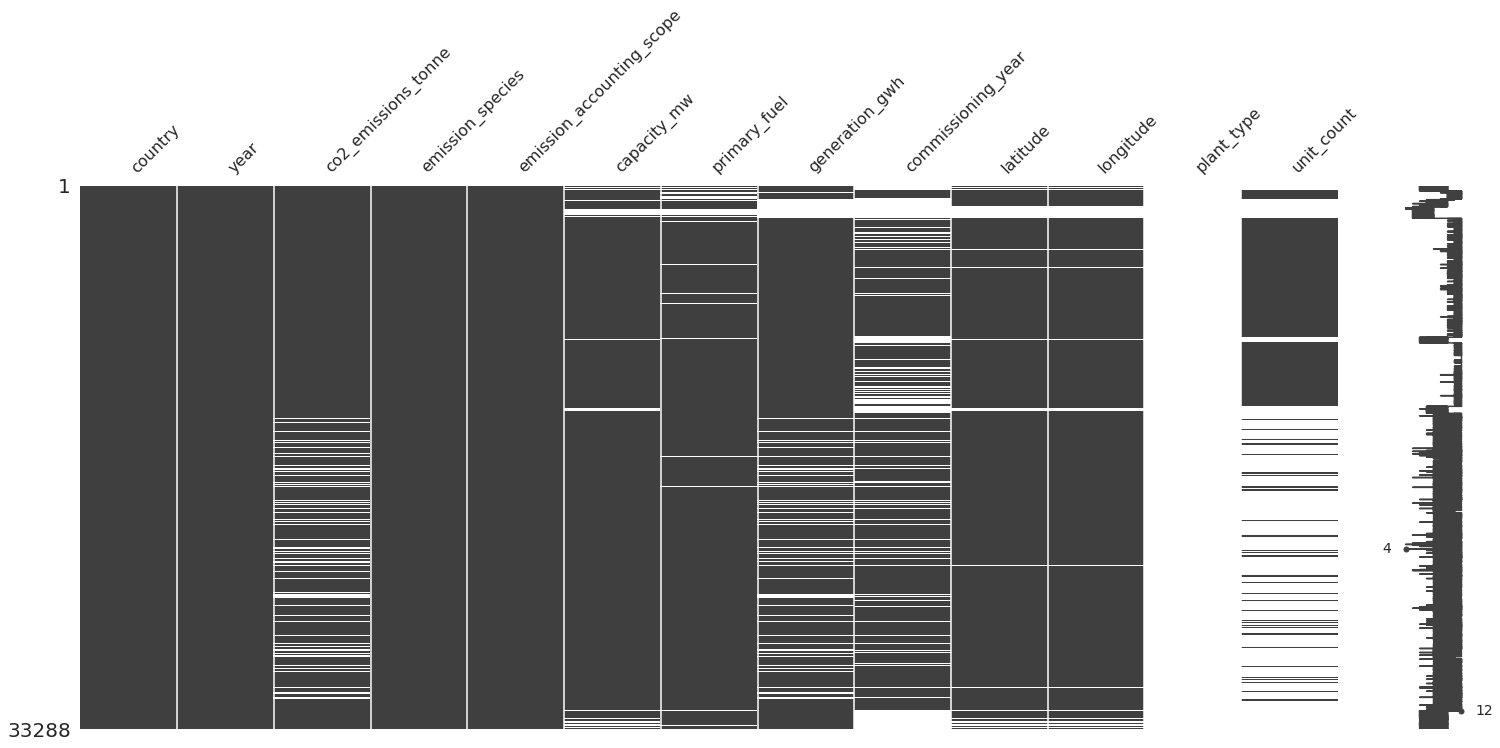

In [14]:
# visualize missing data
msno.matrix(training_master_df_raw)

In [15]:
"""
We will use an imputed dataset later. For now, we are going to only use examples who have all variables
filled (zeroes are included but NaN will be discarded)
"""
training_master_no_plant_type = training_master_df_raw.drop(labels=['plant_type'], axis=1)

In [16]:
# gets a subset will all variables populated
# removes rows that contain zero for co2 emissions
training_master_no_na = training_master_no_plant_type.dropna()
training_master_no_na = training_master_no_na.loc[training_master_no_na['co2_emissions_tonne'] != 0]

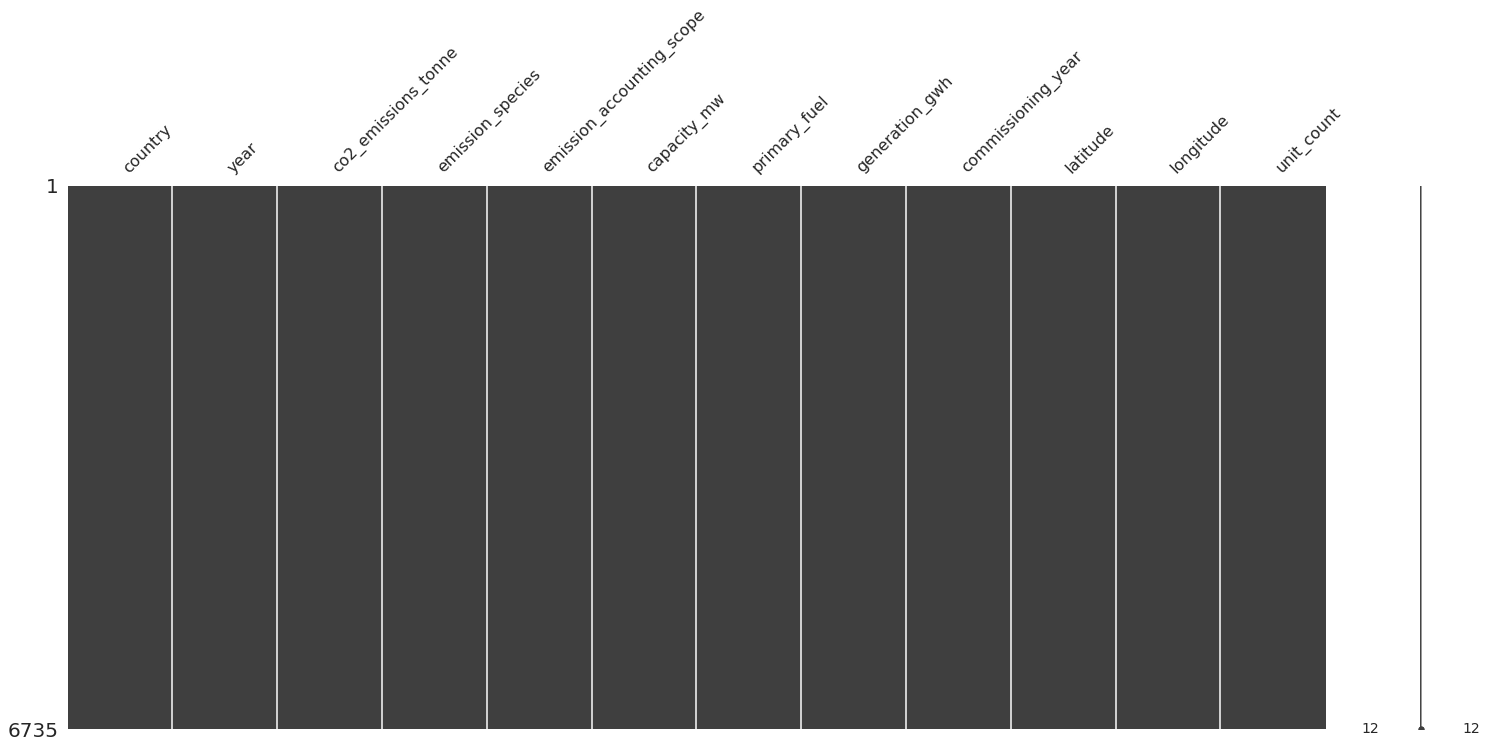

In [17]:
# dropping rows with any NaN reduces the master dataset to ~32% of its size
# big chunk missing so we will have to find a way to keep as many values as possible
msno.matrix(training_master_no_na)

In [18]:
# remove non fossil fuels 
# ignore = [1, 5, 6, 7, 11, 14, 15] # fuels to ignore, by their encoding
ignore = [int(gp.class_coding.code_fuel(fuel)) for fuel in fuels_to_plot]
training_master_less_fuels = training_master_no_na.loc[~((training_master_no_na['primary_fuel']).astype(int).isin(ignore))]

In [19]:
training_master_less_fuels.head(10)

,country,year,co2_emissions_tonne,emission_species,emission_accounting_scope,capacity_mw,primary_fuel,generation_gwh,commissioning_year,latitude,longitude,unit_count
319,1,2017,3.602937e+05,0,1,135.00,4.0,663.774500,2004.0,32.3220,65.1190,6.0
320,1,2017,5.224012e+06,0,1,1800.00,2.0,5385.579736,2015.0,34.5560,69.4787,3.0
321,1,2017,1.516057e+06,0,1,250.00,2.0,1147.913000,2005.0,34.6410,69.7170,2.0
325,1,2017,1.564368e+06,0,1,210.00,2.0,1563.457000,2008.0,34.5865,69.7757,5.0
326,1,2017,4.349411e+06,0,1,1350.00,2.0,4350.558000,2014.0,39.9116,20.1047,5.0
328,1,2017,6.644127e+06,0,1,1200.00,2.0,7940.740000,2011.0,42.1033,19.8224,2.0
331,1,2017,1.489732e+07,0,1,2630.00,2.0,15334.876300,1989.0,41.6796,19.8936,7.0
332,1,2017,2.086250e+05,0,1,419.33,4.0,430.000000,2015.0,42.0137,19.6359,4.0
333,1,2017,5.985070e+06,0,1,1200.00,2.0,5777.120000,1989.0,40.4874,19.4340,2.0
334,1,2017,1.826610e+05,0,1,652.00,4.0,357.000000,2017.0,35.8665,6.0262,6.0


In [20]:
fuels_analyzed = [gp.class_coding._get_fuel_name(code) for code in training_master_less_fuels['primary_fuel'].unique()]

In [21]:
fuels_analyzed

['gas', 'coal', 'oil', 'waste', 'other', 'cogeneration']

In [22]:
seed(1)
df_train, df_test, df_val = gp.data_parser.train_val_test_split(training_master_less_fuels, seed=SEED)

In [23]:
# These will be used for training
train_x, train_y = gp.data_parser.x_y_split(df_train)
test_x, test_y = gp.data_parser.x_y_split(df_test)
val_x, val_y = gp.data_parser.x_y_split(df_val)

# Data Summary
We can get a clearer sense of which variables appear to be the most correlated to CO$_2$ emissions. Generation has the best correlation, and capacity follows second. Other variables will have to be tested to see if they improve model performance.

Dropping any rows containing NaN values reduces the dataset to 32% of its original size. Dropping the fuels that are biomass, geothermal, hydro, nuclear, solar, wave and tidal, and wind reduces the dataset to 21% of its original size. Dropping rows with zero emissions reduces even further to 20.32% of the original size. Therefore, we are working with 6,481 data points.

Suspect column labels that we should consider imputing or dropping altogether seem to be:
- generation_gwh (this is highly correlated, so we are strongly encouraged to impute these values)
- commissioning_year
- unit_count

                           count          min           max           mean  \
country                    33288     1.000000  3.100000e+01       4.600487   
year                       33288  2004.000000  2.018000e+03    2014.488044   
co2_emissions_tonne        29494  -861.699000  3.811422e+07  483260.408880   
emission_species           33288     0.000000  1.000000e+00       0.066961   
emission_accounting_scope  33288     1.000000  1.000000e+00       1.000000   
capacity_mw                32153     0.000000  7.113600e+04     410.560382   
primary_fuel               31872     1.000000  1.500000e+01       7.495043   
generation_gwh             28972  -989.619000  3.511600e+04     788.405131   
commissioning_year         25429  1896.000000  2.019000e+03    1991.092835   
latitude                   31653   -77.847000  7.187861e+01      35.986241   
longitude                  31653  -188.551181  1.667271e+02     -70.228470   
plant_type                     0          NaN           NaN     

KeyboardInterrupt: 

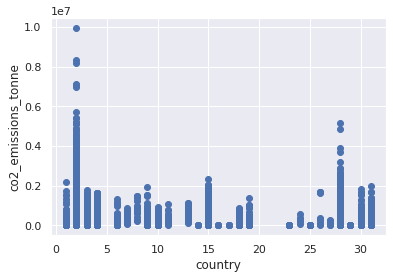

In [24]:
gp.data_viz.plot_stats(MASTER_PATH, fuels_to_plot=fuels_analyzed)

# Models
In this section, we create various models to predict CO$_2$ emissions of power plants given predictor variables.
We develop a linear regression model as a baseline, where we experiment using all variables to using only
the most linearly correlated variables. We then systematically implement neural network models as our model.

## Helper Functions

### <font color='red'>From Terry: The errors derived from scaled y values looks small but can be hard to interprete. Modified the model_summary function a little bit to let it be able to inverse transform the scaled y values given the scaler.</font>

In [148]:
def min_max_scale(df):
    """ Given a dataframe, return a minmaxed scaled dataframe
    """
    mm_scaler = preprocessing.MinMaxScaler()
    names = df.columns
    df_scaled = pd.DataFrame(mm_scaler.fit_transform(df))
    df_scaled.columns = names
    
    return df_scaled

def plot_prediction_scatter(y_true, y_pred):
    plt.scatter(y_true, y_pred)
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.show()
    
# buggy
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.squeeze(y_true), np.squeeze(y_pred)
    mape = metrics.mean_absolute_error([1] * len(y_true), y_true / y_pred)
#     y_true, y_pred = np.array(y_true), np.array(y_pred)
#     mape = np.mean(np.abs((y_true - y_pred) / (y_true)))
    return mape

def print_error_stats(y_true, y_pred):
    """
    Prints error stats given the predicted values vs the actual values.
    """
    print("Coefficient of Determination:", metrics.r2_score(y_true, y_pred))
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_true, y_pred))  
    print('Mean Squared Error:', metrics.mean_squared_error(y_true, y_pred))  
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_true, y_pred)))
    # MAPE is buggy, so exlcuding this from metrics for now
#     print("Mean Absolute Percentage Error:", mean_absolute_percentage_error(y_true, y_pred))
    print('\n')
    
def plot_train_test_errors(y_train, y_pred_train, y_test, y_pred_test):
    """
    Plots the training and test errors for a regression model as bar graphs. This will
    allow the user to see any over-fitting, variance, or bias the model may have.
    
    Parameters
    y_train: pd.Series, the true train values
    y_pred_train: pd.Series, the predicted values from x_train by model fitted onto the training set
    y_test: pd.Series, the true test values
    y_pred_test: pd.Series, the predicted test values from x_test by the model fitted onto the training set
    
    References
    https://pythonspot.com/matplotlib-bar-chart/
    """
    
    # train stats
    train_cod = metrics.r2_score(y_train, y_pred_train)
    train_mae = metrics.mean_absolute_error(y_train, y_pred_train)
    train_mse = metrics.mean_squared_error(y_train, y_pred_train)
    train_rmse = np.sqrt(train_mse)
    
    # test stats
    test_cod = metrics.r2_score(y_test, y_pred_test)
    test_mae = metrics.mean_absolute_error(y_test, y_pred_test)
    test_mse = metrics.mean_squared_error(y_test, y_pred_test)
    test_rmse = np.sqrt(test_mse)
    
    # set up label variables
    objects = ('Train', 'Test')
    y_pos = [0,0.3]

    # plot cod comparison
    cod_performance = [train_cod, test_cod]
    plt.bar(y_pos, cod_performance, align='center', alpha=0.5, width=0.2)
    plt.xticks(y_pos, objects)
    plt.ylabel('COD')
    plt.title('Coefficient of Determination')
    plt.show()
    
    # plot mse comparison
    mse_performance = [train_mse, test_mse]
    plt.bar(y_pos, mse_performance, align='center', alpha=0.5, width=0.2)
    plt.xticks(y_pos, objects)
    plt.ylabel('Error')
    plt.title('Mean Squared Error')
    plt.show()
    
    # plot mae comparison
    mae_performance = [train_mae, test_mae]
    plt.bar(y_pos, mae_performance, align='center', alpha=0.5, width=0.2)
    plt.xticks(y_pos, objects)
    plt.ylabel('Error')
    plt.title('Mean Absolute Error')
    plt.show()
    
    # plot rmse comparison
    rmse_performance = [train_rmse, test_rmse]
    plt.bar(y_pos, rmse_performance, align='center', alpha=0.5, width=0.2)
    plt.xticks(y_pos, objects)
    plt.ylabel('RMSE')
    plt.title("Root Mean Square Error")
    plt.show()
    
def plot_prediction_bar(y_true, y_pred, num_samples=40, title=""):
#     set_trace()
    compare_df_train = pd.DataFrame({'Actual': y_true, 'Predicted': y_pred.flatten()})
    small_compare_train = compare_df_train.head(num_samples)
    small_compare_train.plot(kind='bar',figsize=(10,8))
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    plt.title(title)
    plt.show()
    
# Terry: added a scaler parameter for inverse transformation, but need to make sure pass in the original y_train and y_test (not scaled) for consistency
def model_summary(model, x_train, x_test, y_train, y_test, num_samples=40, scaler = None):
    """
    Given a model, summarizes performance by comparing true target values 
    vs predicted target values
    
    Parameters
    model: model-like, can be a keras or scikit linear regression model object, must be already trained
    x: array-like, the training data
    y_true: array-like, the true target
    num_samples: int, subset of data points to plot to get a grasp of model performance
    """
    # From Terry
    if scaler != None:
        print("You are passing in a scaler for inverse transform. Make sure the y_trian and y_test are original values and not scaled")
        
    # predict target values
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    
    if scaler != None:
        y_train_pred = scaler.inverse_transform(y_train_pred)
        y_test_pred = scaler.inverse_transform(y_test_pred)
    
    # plot and print training info
    print("Training Set Stats")
    print_error_stats(y_train, y_train_pred)
    plot_prediction_bar(y_train, y_train_pred, num_samples=num_samples, title="Training Set Predictions")
    plot_prediction_scatter(y_train, y_train_pred)
    print("\n")
    
    # plot and print test info
    print("Test Set Stats")
    print_error_stats(y_test, y_test_pred)
    plot_prediction_bar(y_test, y_test_pred, num_samples=num_samples, title="Test Set Predictions")
    plot_prediction_scatter(y_test, y_test_pred)
    print("\n")
    
    # compare Training and Test Errors
    plot_train_test_errors(y_train, y_train_pred, y_test, y_test_pred)

# def compare_models(x_test, y_test, **kwargs):
    
# #     predictions = {model_name:predictions for}
#     for model_name, model in kwargs.items():
        
#         # plot COD comparison
        

In [26]:
# scaled data
seed(1)
master_reduced_scaled = min_max_scale(training_master_less_fuels) 
scaled_train, scaled_test, scaled_val = gp.data_parser.train_val_test_split(master_reduced_scaled, seed=SEED)
train_scaled_x, train_scaled_y = gp.data_parser.x_y_split(scaled_train)
test_scaled_x, test_scaled_y = gp.data_parser.x_y_split(scaled_test)
val_scaled_x, val_scaled_y = gp.data_parser.x_y_split(scaled_val)

### <font color='red'>From Terry: It might be better to create a scaler fitted on training data and then apply the scaler to val/test data to avoid data distribution leaking.</font>

In [27]:
# scaled data (Terry suggest)
def to_2d(arr):
    return np.array(arr).reshape(-1,1)

seed(1)
train, test, val = gp.data_parser.train_val_test_split(training_master_less_fuels, seed=SEED)

train_x, train_y = gp.data_parser.x_y_split(train)
test_x, test_y = gp.data_parser.x_y_split(test)
val_x, val_y = gp.data_parser.x_y_split(val)

mm_scaler_X = preprocessing.MinMaxScaler().fit(train_x)
mm_scaler_y = preprocessing.MinMaxScaler().fit(to_2d(train_y))

train_scaled_x = pd.DataFrame(mm_scaler_X.transform(train_x))
train_scaled_x.columns = train_x.columns
train_scaled_y = mm_scaler_y.transform(to_2d(train_y))

test_scaled_x = pd.DataFrame(mm_scaler_X.transform(test_x))
test_scaled_x.columns = test_x.columns
test_scaled_y = mm_scaler_y.transform(to_2d(test_y))

val_scaled_x = pd.DataFrame(mm_scaler_X.transform(val_x))
val_scaled_x.columns = val_x.columns
val_scaled_y = mm_scaler_y.transform(to_2d(val_y))


## Linear Regression

### Linear Regression Helper Functions

In [28]:
def run_linreg_model(x_train, y_train, x_test, y_test):
    """
    Given train and test datasets, trains the model and measures its
    performance against the test set. Returns stats.
    
    Reference
    https://towardsdatascience.com/a-beginners-guide-to-linear-regression-in-python-with-scikit-learn-83a8f7ae2b4f
    """
    # define the model
    model = LinearRegression()
    
    # train the model
    model.fit(X=x_train, y=y_train)
    
    # print parameters
    coeff_df = pd.DataFrame(model.coef_, x_train.columns, columns=["Parameters"])
    print(coeff_df, '\n')
    
    # TODO: color code scatterplot
#     model_summary(model, x_train, y_train) # this should be used to test model performance
    
#     # predict on unseen test data
#     model_summary(model, x_test, y_test)

    model_summary(model, x_train, x_test, y_train, y_test, num_samples=40)

### Tests and Model Performance

#### Unscaled data

                             Parameters
country                   -3.575798e+04
year                       1.902772e+04
emission_species           6.212986e-10
emission_accounting_scope  4.433787e-12
capacity_mw                1.097624e+02
primary_fuel              -9.831010e+02
generation_gwh             9.322904e+02
commissioning_year        -1.136702e+04
latitude                   2.720614e+03
longitude                 -1.445146e+02
unit_count                -1.331355e+04 

Training Set Stats
Coefficient of Determination: 0.9363933024222549
Mean Absolute Error: 472344.6144785626
Mean Squared Error: 707483737240.4976
Root Mean Squared Error: 841120.5248003984




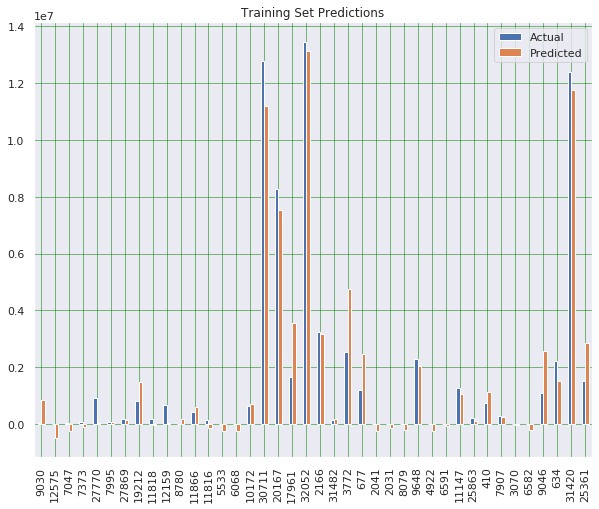

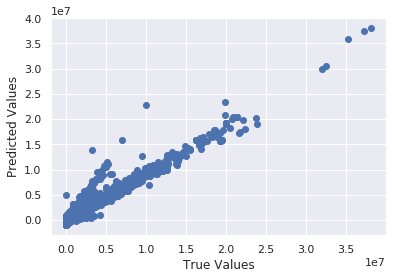



Test Set Stats
Coefficient of Determination: 0.9176228261181162
Mean Absolute Error: 493214.2032630699
Mean Squared Error: 838895829692.4028
Root Mean Squared Error: 915912.5666199819




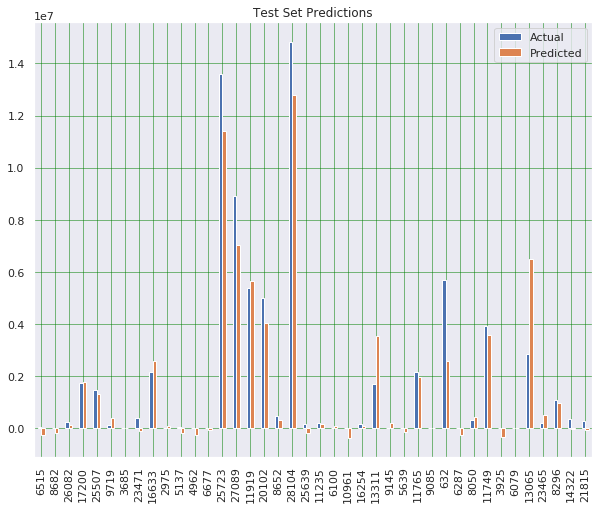

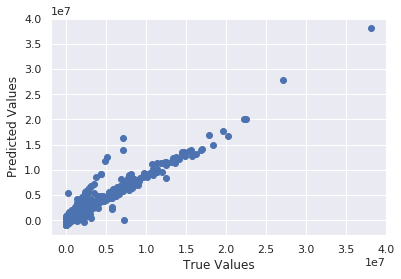

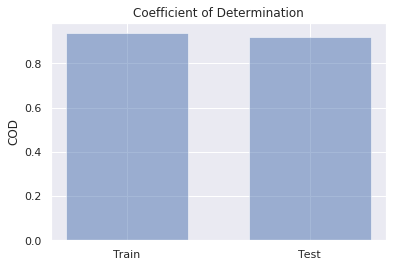

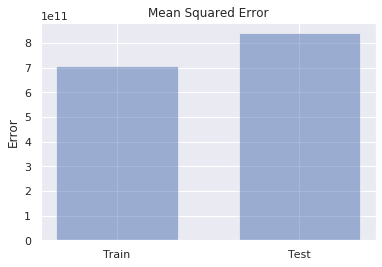

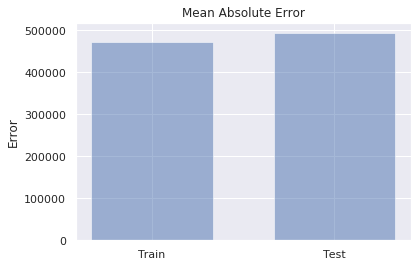

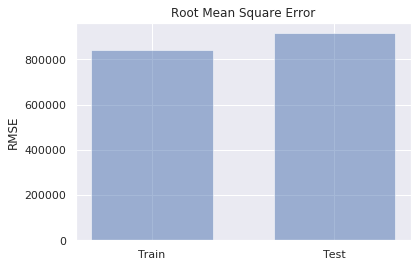

In [29]:
seed(1)
run_linreg_model(train_x, train_y, test_x, test_y)

#### Scaled Data

In [30]:
master_reduced_scaled.head()

,country,year,co2_emissions_tonne,emission_species,emission_accounting_scope,capacity_mw,primary_fuel,generation_gwh,commissioning_year,latitude,longitude,unit_count
0,0.0,0.833333,0.009475,0.0,0.0,0.001898,0.181818,0.023804,0.882353,0.688435,0.728406,0.076923
1,0.0,0.833333,0.137082,0.0,0.0,0.025304,0.000000,0.166412,0.974790,0.706296,0.741813,0.030769
2,0.0,0.833333,0.039798,0.0,0.0,0.003514,0.000000,0.038426,0.890756,0.706975,0.742546,0.015385
3,0.0,0.833333,0.041066,0.0,0.0,0.002952,0.000000,0.050976,0.915966,0.706540,0.742727,0.061538
4,0.0,0.833333,0.114135,0.0,0.0,0.018978,0.000000,0.135153,0.966387,0.749114,0.589973,0.061538


In [ ]:
seed(1)
run_linreg_model(train_scaled_x, train_scaled_y, test_scaled_x, test_scaled_y)

# Neural Networks

## Helper Functions

In [50]:
def plot_loss_error(history, loss):
    """
    Given a history object, plots the MSE vs num_epochs.
    
    Parameters
    history: History, a history object produced by fitting the model
    """
    
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.title('Model Performance')
    plt.xlabel('Epoch')
    plt.ylabel(loss)
    plt.plot(hist['epoch'], hist[loss],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_' + loss],
           label = 'Val Error')
    
#     plot_ceiling = max(hist['val_mean_squared_error'])
#     plt.xlim([0,epochs])
#     plt.ylim([0, plot_ceiling])
    plt.legend()
    plt.show()
    
def build_model_A(input_size, lr, reg, objective=''):
    # Build model
    model = keras.Sequential()
    num_neurons = 100
    
    # Input layer
    model.add(keras.layers.Dense(num_neurons, input_dim=input_size, activation='relu', use_bias=True,
                                    activity_regularizer=keras.regularizers.l2(reg)))
    
    # Output layer
    model.add(keras.layers.Dense(1))
    
    # Optimizer. Can change this to whatever we want
    optimizer = keras.optimizers.RMSprop(lr)
    
    # Compile model
    model.compile(loss=objective,
                optimizer=optimizer,
                metrics=[objective])
    return model

def build_model_B(input_size, lr, reg, objective=''):
    # build model
    model = keras.Sequential()
    num_neuron_layer_1 =100
    num_neuron_layer_2 = 50
    
    model.add(keras.layers.Dense(num_neuron_layer_1, input_dim=input_size, activation='relu', use_bias=True,
                               activity_regularizer=keras.regularizers.l2(reg)))
    model.add(keras.layers.Dense(num_neuron_layer_2, activation='relu', use_bias=True,
                               activity_regularizer=keras.regularizers.l2(reg)))
    model.add(keras.layers.Dense(1))
    
    optimizer = keras.optimizers.RMSprop(lr)
    
    model.compile(loss=objective,
                 optimizer=optimizer,
                 metrics=[objective])
    
    return model

## Mean Squared Error Model

### Model A

In [77]:
model_A_mse = build_model_A(input_size=len(train_x.columns), lr=0.0001, reg=0.003, objective='mean_squared_error',model_save_path = 'model_A_mse.h5')

### <font color='red'>From Terry: How did you determine the number of epochs? Maybe a more systematic way is using early stop.</font>

In [78]:
callbacks = [EarlyStopping(monitor='val_loss',patience=25),
             ModelCheckpoint(filepath='model_A_mse.h5', monitor='val_loss', save_best_only=True)]

In [ ]:
%%time
hist_A_mse = model_A_mse.fit(train_scaled_x, train_scaled_y, epochs=500, callbacks=callbacks, verbose=1,
         validation_data=(val_scaled_x, val_scaled_y))

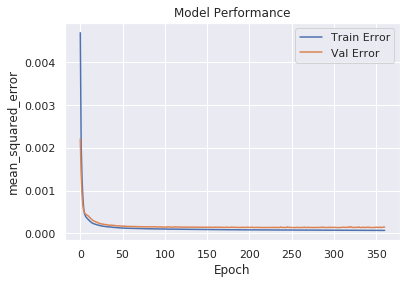

In [80]:
plot_loss_error(hist_A_mse, 'mean_squared_error')

In [81]:
# Error rate in Test
201339.09987655122/test_y.mean()

0.13206825399247632

In [82]:
# Error rate in train
171678.6550429794/train_y.mean()

0.11339522125825136

### <font color='red'>From Terry: Comparing the MAE with the mean of target variable in both train and test set, we can tell the error rate is roughly 13% and 11% in train and test, respectively. The actual MAPEs should be close to these. This is a big improvement upon linear regression</font>

You are passing in a scaler for inverse transform. Make sure the y_trian and y_test are original values and not scaled
Training Set Stats
Coefficient of Determination: 0.990849239470698
Mean Absolute Error: 173356.44722258163
Mean Squared Error: 101781958573.62901
Root Mean Squared Error: 319032.848737601




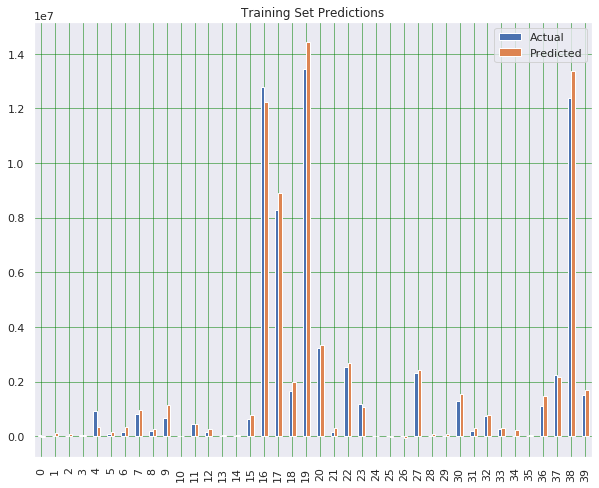

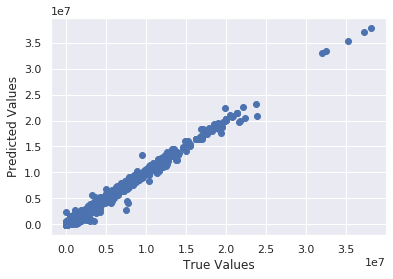



Test Set Stats
Coefficient of Determination: 0.9801500826467515
Mean Absolute Error: 209939.7886671779
Mean Squared Error: 202143532032.98096
Root Mean Squared Error: 449603.75002103904




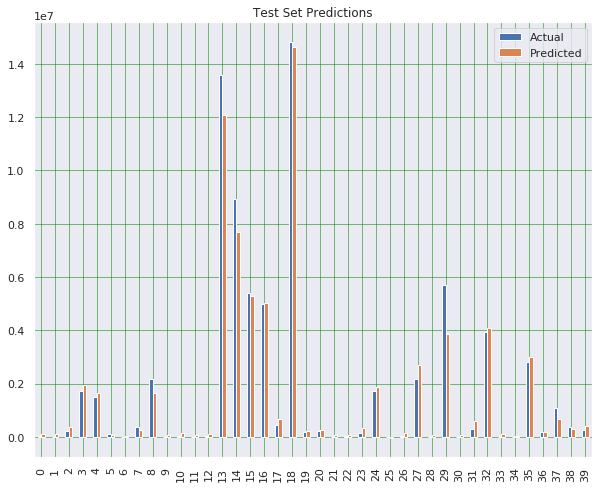

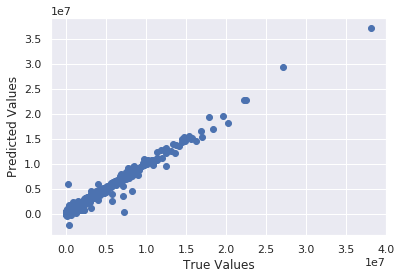

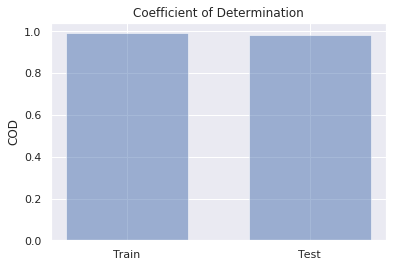

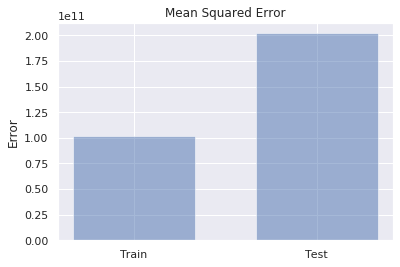

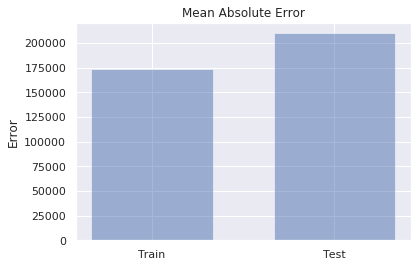

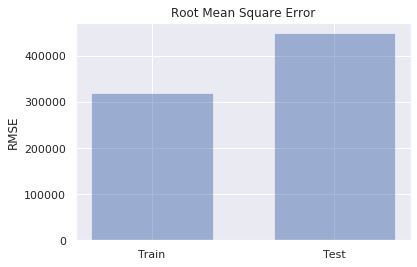

In [83]:
# make a prediction on the test set and compare results
model_summary(model_A_mse, train_scaled_x, test_scaled_x, np.array(train_y), np.array(test_y), num_samples=40,scaler = mm_scaler_y)

### Model B

In [94]:
model_B_mse = build_model_B(len(train_x.columns), lr=0.0001, reg=0.0001, objective='mean_squared_error')

In [96]:
callbacks = [EarlyStopping(monitor='val_loss',patience=25),
             ModelCheckpoint(filepath='model_B_mse.h5', monitor='val_loss', save_best_only=True)]

In [ ]:
%%time
hist_B_mse = model_B_mse.fit(train_scaled_x, train_scaled_y, callbacks=callbacks, epochs=500, verbose=1,
                            validation_data=(val_scaled_x, val_scaled_y))

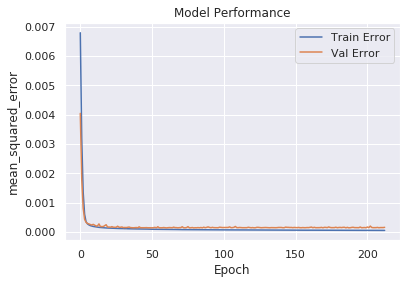

In [98]:
plot_loss_error(hist_B_mse, 'mean_squared_error')

You are passing in a scaler for inverse transform. Make sure the y_trian and y_test are original values and not scaled
Training Set Stats
Coefficient of Determination: 0.9907150453549226
Mean Absolute Error: 205773.94683226498
Mean Squared Error: 103274571115.38843
Root Mean Squared Error: 321363.61199642444




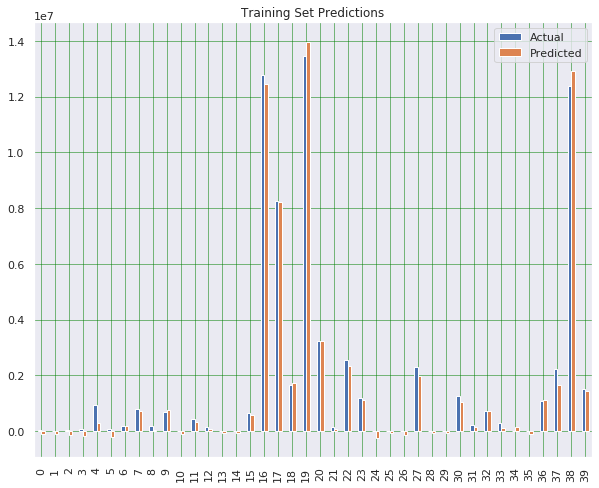

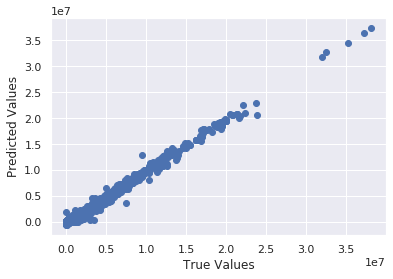



Test Set Stats
Coefficient of Determination: 0.9792218696921271
Mean Absolute Error: 246051.74353772934
Mean Squared Error: 211596077440.97733
Root Mean Squared Error: 459995.73632912873




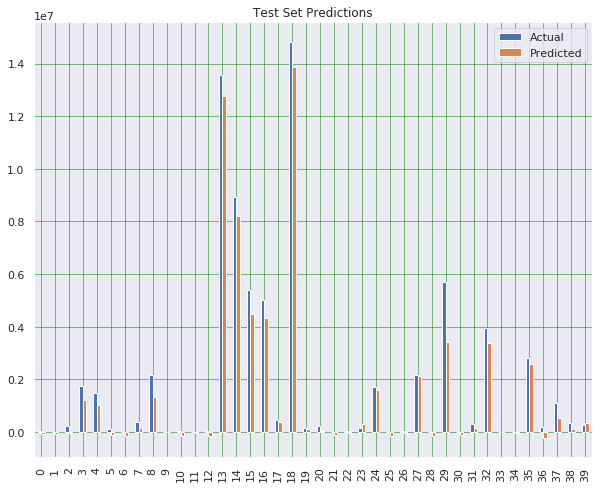

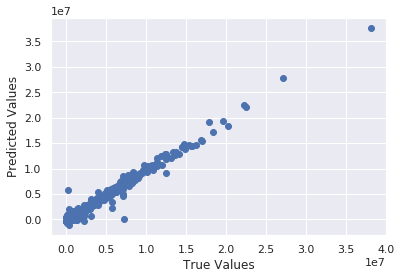

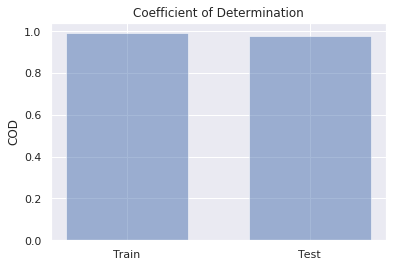

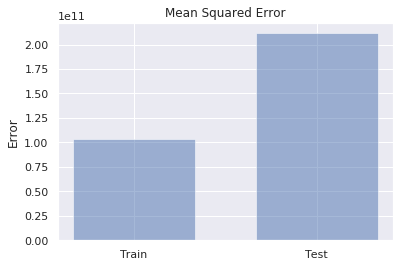

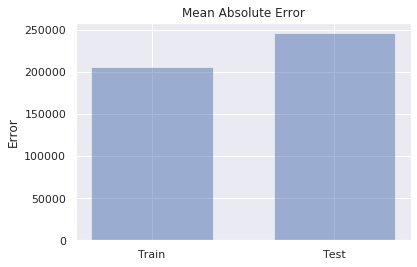

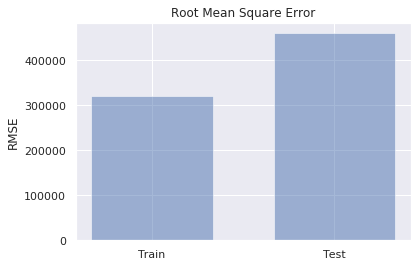

In [99]:
model_summary(model_B_mse, train_scaled_x, test_scaled_x, np.array(train_y), np.array(test_y), num_samples=40,scaler=mm_scaler_y)

## Mean Absolute Error Model

In [160]:
model_A_mae = build_model_A(input_size=len(train_x.columns), lr=0.0001, reg=0.1, objective='mean_absolute_error')

In [161]:
callbacks = [EarlyStopping(monitor='val_loss',patience=25),
             ModelCheckpoint(filepath='model_A_mae.h5', monitor='val_loss', save_best_only=True)]

In [ ]:
%%time
hist_A_mae = model_A_mae.fit(train_scaled_x, train_scaled_y, callbacks=callbacks, epochs=1000, verbose=1,
         validation_data=(val_scaled_x, val_scaled_y))

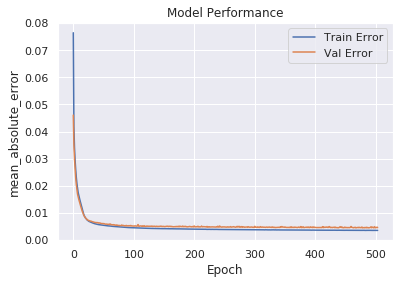

In [163]:
plot_loss_error(hist_A_mae, 'mean_absolute_error')

### <font color='red'>Error rate on train and test with reported generation ↓</font>

In [119]:
130434.24488863912/train_y.mean()

0.08615293529121236

In [165]:
166285.94366595373/test_y.mean()

0.10907515856045338

You are passing in a scaler for inverse transform. Make sure the y_trian and y_test are original values and not scaled
Training Set Stats
Coefficient of Determination: 0.990224206593749
Mean Absolute Error: 134493.0083512922
Mean Squared Error: 108734066017.0564
Root Mean Squared Error: 329748.4890292242




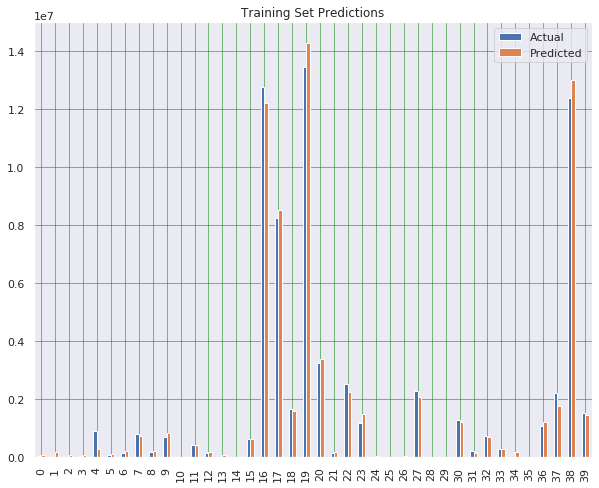

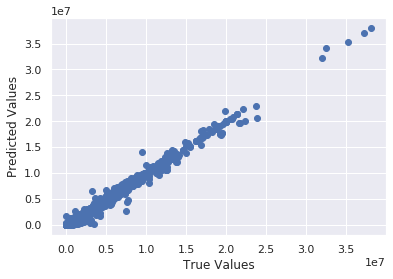



Test Set Stats
Coefficient of Determination: 0.9814320748804216
Mean Absolute Error: 166285.94366595373
Mean Squared Error: 189088241497.4509
Root Mean Squared Error: 434842.7779065106




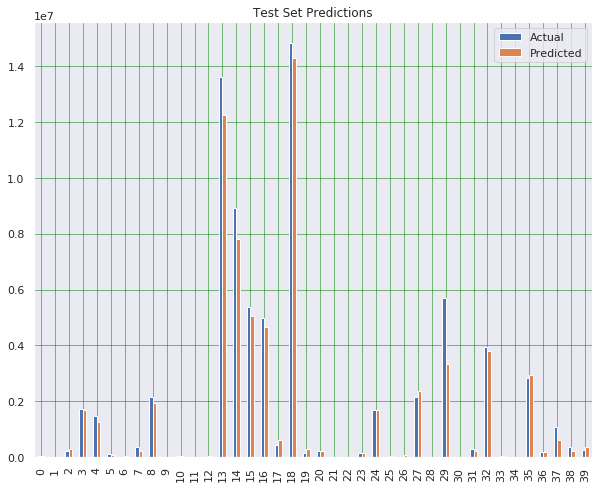

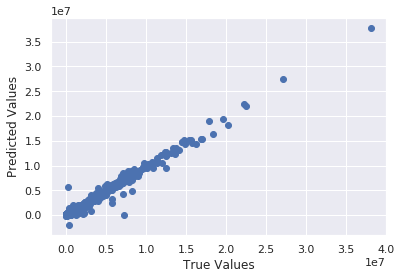

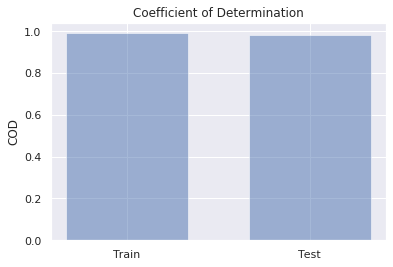

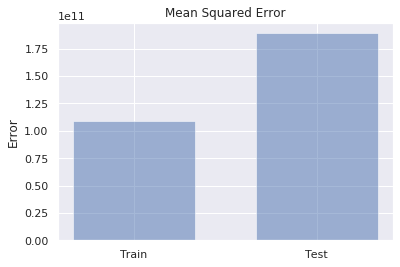

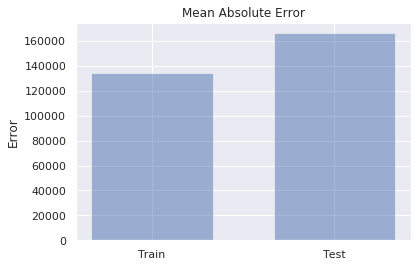

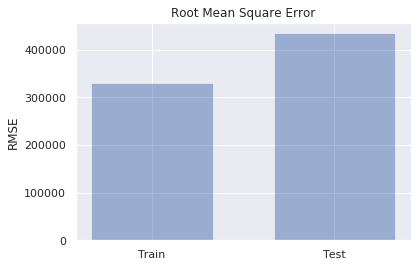

In [164]:
model_summary(model_A_mae, train_scaled_x, test_scaled_x, np.array(train_y), np.array(test_y), num_samples=40,scaler = mm_scaler_y)

## Mean Absolute Percentage Error Model

In [ ]:
# model_A_mape = build_model_A(input_size=len(train_x.columns), lr=0.0001, reg=0.0006, objective='mean_absolute_percentage_error')

In [ ]:
# %%time
# hist_A_mape = model_A_mape.fit(train_scaled_x, train_scaled_y, epochs=100, verbose=0,
#          validation_data=(val_scaled_x, val_scaled_y))

In [ ]:
# plot_loss_error(hist_A_mape, 'mean_absolute_percentage_error')

In [ ]:
# model_summary(model_A_mape, train_scaled_x, test_scaled_x, train_scaled_y, test_scaled_y, num_samples=40)

## CO2 Estimations without generation_gwh

In [109]:
# drop the generation_ghw column
master_no_gen = master_reduced_scaled.drop(labels=['generation_gwh'], axis=1)
master_no_gen.head()

,country,year,co2_emissions_tonne,emission_species,emission_accounting_scope,capacity_mw,primary_fuel,commissioning_year,latitude,longitude,unit_count
0,0.0,0.833333,0.009475,0.0,0.0,0.001898,0.181818,0.882353,0.688435,0.728406,0.076923
1,0.0,0.833333,0.137082,0.0,0.0,0.025304,0.000000,0.974790,0.706296,0.741813,0.030769
2,0.0,0.833333,0.039798,0.0,0.0,0.003514,0.000000,0.890756,0.706975,0.742546,0.015385
3,0.0,0.833333,0.041066,0.0,0.0,0.002952,0.000000,0.915966,0.706540,0.742727,0.061538
4,0.0,0.833333,0.114135,0.0,0.0,0.018978,0.000000,0.966387,0.749114,0.589973,0.061538


In [ ]:
# scaled_train, scaled_test, scaled_val = gp.data_parser.train_val_test_split(master_no_gen, seed=SEED)
# train_scaled_x, train_scaled_y = gp.data_parser.x_y_split(scaled_train)
# test_scaled_x, test_scaled_y = gp.data_parser.x_y_split(scaled_test)
# val_scaled_x, val_scaled_y = gp.data_parser.x_y_split(scaled_val)

In [174]:
# scaled data (Terry suggest)
master_no_gen = training_master_less_fuels.drop(labels=['generation_gwh'], axis=1)

def to_2d(arr):
    return np.array(arr).reshape(-1,1)

seed(1)
train, test, val = gp.data_parser.train_val_test_split(master_no_gen, seed=SEED)

train_x, train_y = gp.data_parser.x_y_split(train)
test_x, test_y = gp.data_parser.x_y_split(test)
val_x, val_y = gp.data_parser.x_y_split(val)

mm_scaler_X = preprocessing.MinMaxScaler().fit(train_x)
mm_scaler_y = preprocessing.MinMaxScaler().fit(to_2d(train_y))

train_scaled_x = pd.DataFrame(mm_scaler_X.transform(train_x))
train_scaled_x.columns = train_x.columns
train_scaled_y = mm_scaler_y.transform(to_2d(train_y))

test_scaled_x = pd.DataFrame(mm_scaler_X.transform(test_x))
test_scaled_x.columns = test_x.columns
test_scaled_y = mm_scaler_y.transform(to_2d(test_y))

val_scaled_x = pd.DataFrame(mm_scaler_X.transform(val_x))
val_scaled_x.columns = val_x.columns
val_scaled_y = mm_scaler_y.transform(to_2d(val_y))

## Model A

In [121]:
model_A_mse = build_model_A(len(train_scaled_x.columns), lr=0.0001, reg=0.0001, objective='mean_squared_error')

In [122]:
%%time
hist_A_mse = model_A_mse.fit(train_scaled_x, train_scaled_y, epochs=100, verbose=0,
         validation_data=(val_scaled_x, val_scaled_y))

CPU times: user 23.9 s, sys: 711 ms, total: 24.6 s
Wall time: 20.1 s


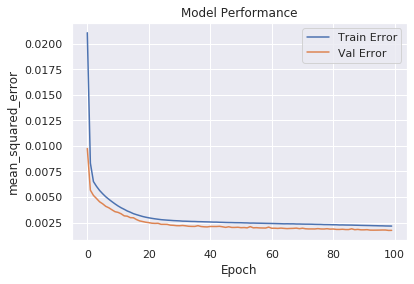

In [123]:
plot_loss_error(hist_A_mse, 'mean_squared_error')

In [ ]:
# make a prediction on the test set and compare results
model_summary(model_A_mse, train_scaled_x, test_scaled_x, train_scaled_y, test_scaled_y, num_samples=40)

In [125]:
928523.8514911935/train_y.mean()

0.6132979522529952

In [126]:
964641.2232495351/test_y.mean()

0.6327557943879036

You are passing in a scaler for inverse transform. Make sure the y_trian and y_test are original values and not scaled
Training Set Stats
Coefficient of Determination: 0.7164488879037305
Mean Absolute Error: 928523.8514911935
Mean Squared Error: 3153878571346.5103
Root Mean Squared Error: 1775916.2624815705




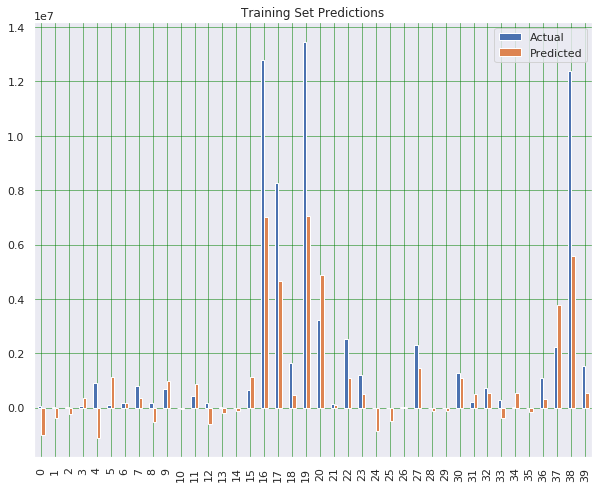

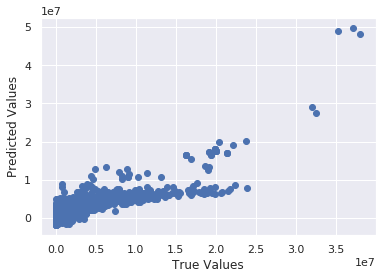



Test Set Stats
Coefficient of Determination: 0.6760632516008511
Mean Absolute Error: 964641.2232495351
Mean Squared Error: 3298840862224.888
Root Mean Squared Error: 1816271.1422650772




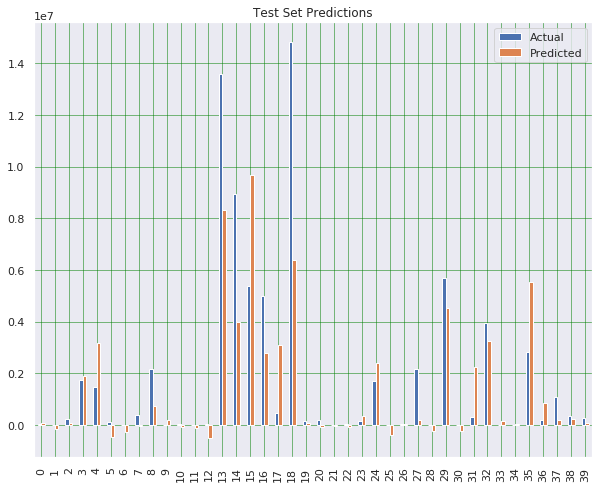

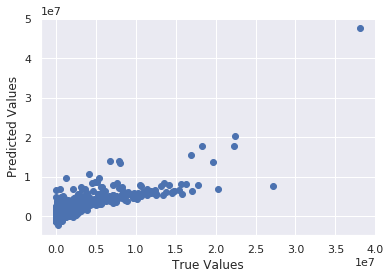

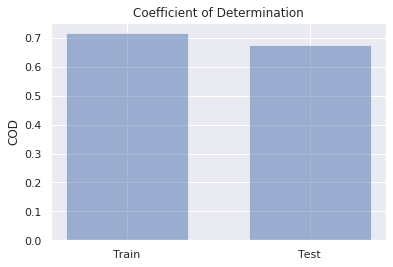

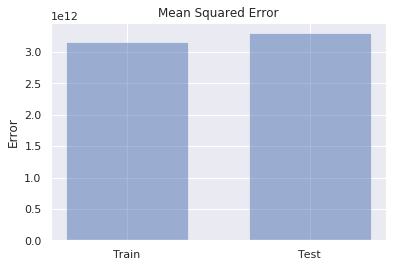

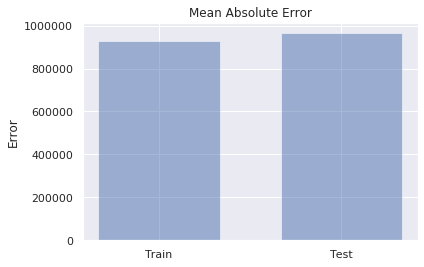

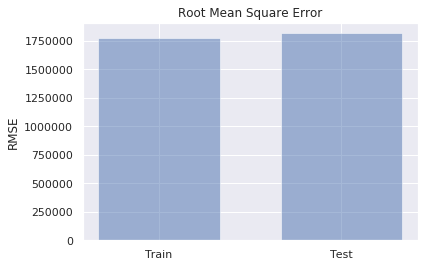

In [124]:
model_summary(model_A_mse, train_scaled_x, test_scaled_x, np.array(train_y), np.array(test_y), num_samples=40,scaler = mm_scaler_y)

## Model A (mae)

In [187]:
model_A_mae = build_model_A(len(train_scaled_x.columns), lr=0.0001, reg=0.1, objective='mean_absolute_error')

In [188]:
callbacks = [EarlyStopping(monitor='val_loss',patience=25),
             ModelCheckpoint(filepath='model_A_mae_no_gen.h5', monitor='val_loss', save_best_only=True)]

In [ ]:
%%time
hist_A_mae = model_A_mae.fit(train_scaled_x, train_scaled_y, callbacks=callbacks, epochs=1000, verbose=1,
         validation_data=(val_scaled_x, val_scaled_y))

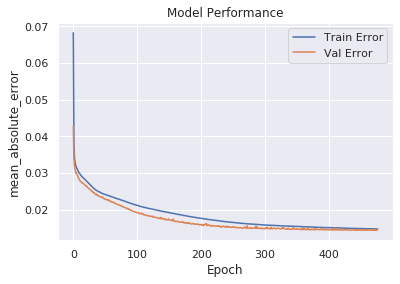

In [190]:
plot_loss_error(hist_A_mae, 'mean_absolute_error')

You are passing in a scaler for inverse transform. Make sure the y_trian and y_test are original values and not scaled
Training Set Stats
Coefficient of Determination: 0.7859406970218444
Mean Absolute Error: 565976.1566565513
Mean Squared Error: 2380935993052.8623
Root Mean Squared Error: 1543028.189325413




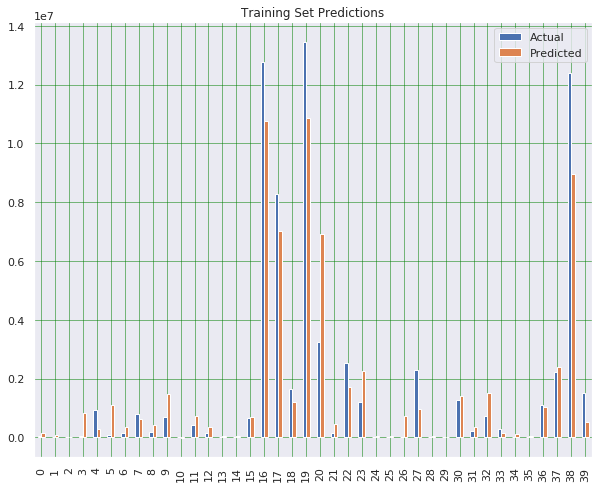

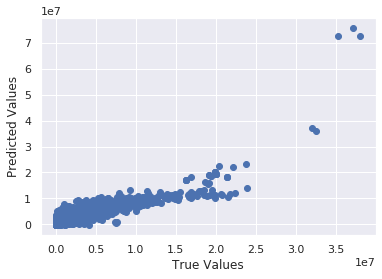



Test Set Stats
Coefficient of Determination: 0.7656737281012298
Mean Absolute Error: 601270.2979334812
Mean Squared Error: 2386284003443.783
Root Mean Squared Error: 1544760.1766759083




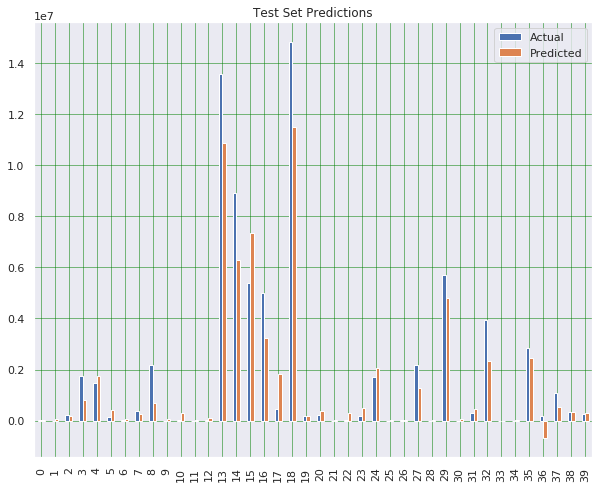

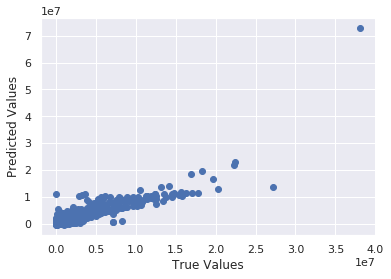

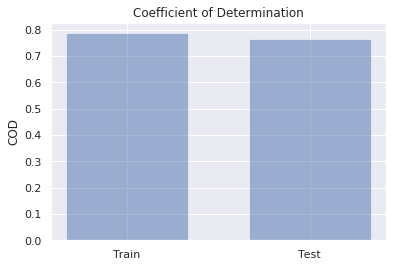

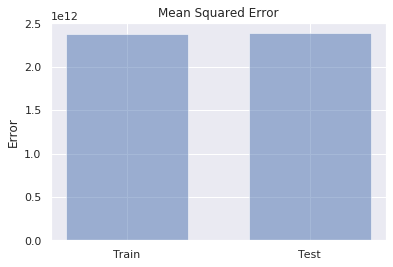

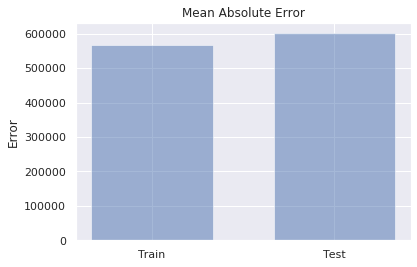

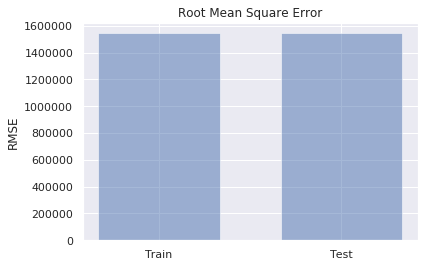

In [191]:
model_summary(model_A_mae, train_scaled_x, test_scaled_x, np.array(train_y), np.array(test_y), num_samples=40,scaler = mm_scaler_y)

### <font color='red'>Error rate on train and test without reported generation ↓</font>

In [193]:
601270.2979334812/test_y.mean()

0.39440286796901075

In [194]:
565976.1566565513/train_y.mean()

0.3738320963365963